## 1. Install VJF (for more information, visit https://github.com/catniplab/vjf)

In [75]:
!pip install git+https://github.com/catniplab/vjf.git

  Cloning https://github.com/catniplab/vjf.git to /tmp/pip-req-build-ckod0he2
  Running command git clone -q https://github.com/catniplab/vjf.git /tmp/pip-req-build-ckod0he2
  Created wheel for vjf: filename=vjf-2018.11.16-py3-none-any.whl size=15500 sha256=9894820d94c345c0ccccebc528a9fd0be15a58c089724820eb289650d5666ad7
  Stored in directory: /tmp/pip-ephem-wheel-cache-244wmr_d/wheels/a6/bd/22/2d48f239ecfe19c0bd595dec620e6cce2bb72f31adaff5a342
Successfully built vjf
  Attempting uninstall: vjf
    Found existing installation: vjf 2018.11.16
    Uninstalling vjf-2018.11.16:
      Successfully uninstalled vjf-2018.11.16


## 2. Import the packages / functions

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from tqdm.notebook import trange

import torch
import vjf
from vjf import online

%matplotlib inline

## 3. Import the dataset
### (run ONLY one of the 6 cells below, depending on the dataset you'd like to run with)
- Van der Pol dataset
- Lorenz attractor dataset
- Monkey reach (jPCA) dataset
- Wide-field calcium dataset
- Mouse video dataset
- Neuropixels dataset

#### run the cell below to load the simulated Van der Pol dataset 

In [86]:
# The data loading below is the vdp with (1 trajectory, 2dim, 500 to 20500 time points, with noise sd=0.05)
# Use any of the simulated vdp dataset. 
# You can generate the simulated data using datagen.py (more info in Readme)
data = np.load('vdp_1trajectories_2dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the simulated Lorenz attractor dataset 

In [78]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 20500 time points, with noise sd=0.05)
# Use any of the simulated lorenz dataset. 
# You can generate the simulated data using datagen.py (See README.md for more info)
data = np.load('lorenz_1trajectories_3dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the reduced Monkey reach (jPCA) dataset

In [80]:
# load the reduced Monkey reach dataset (See README.md for how the reduced dataset was generated.)
data = np.load('jpca_reduced.npy')

xs = None  # state
ys = data  # observation
ys = ys[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = 6
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the reduced Wide-field calcium imaging dataset

In [81]:
# load the reduced Wide-field calcium dataset (See README.md for how the reduced dataset was generated.)
data = np.load('widefield_reduced.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the reduced Mouse video dataset

In [83]:
# load the reduced Mouse video dataset (See README.md for how the reduced dataset was generated.)
data = np.load('reduced_mouse.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example Neuropixels dataset

In [85]:
# load the reduced Neuropixels dataset with the desired latent dimensions
# (See README.md for how the reduced dataset was generated.)
data = np.load('neuropixel_reduced.npz')['ssSVD10'] # you can change this to 'ssSVD20'

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

## 4. Check your data dimension
It should be
`number of trials x number of time points x number of latent dimensions`

In [87]:
ys.shape

(1, 20000, 2)

## 5. Training the model and calculating the log probs

In [88]:
device = 'cpu'

In [89]:
likelihood = 'gaussian'  # Gaussian observation
dynamics = 'rbf'  # RBF network dynamic model
recognizer = "mlp"  # MLP recognitiom model
rdim = 50  # number of RBFs
hdim = 100  # number of MLP hidden units

mdl = online.VJF(
    config=dict(
        resume=False,
        xdim=xdim,
        ydim=ydim,
        udim=udim,
        Ydim=udim,
        Udim=udim,
        rdim=rdim,
        hdim=hdim,
        lr=1e-3,
        clip_gradients=5.0,
        debug=True,
        likelihood=likelihood,  # 
        system=dynamics,
        recognizer=recognizer,
        C=(None, True),  # loading matrix: (initial, estimate)
        b=(None, True),  # bias: (initial, estimate)
        A=(None, False),  # transition matrix if LDS
        B=(np.zeros((xdim, udim)), False),  # interaction matrix
        Q=(1.0, True),  # state noise
        R=(1.0, True),  # observation noise
    )
).to(device)

{'A': (None, False),
 'B': (array([[0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/home/nayoungjun/workspace/vjf/notebook',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'rbf',
 'udim': 1,
 'xdim': 2,
 'ydim': 2}
Gaussian likelihood


In [90]:
yy = torch.from_numpy(ys).float().to(device)
uu = torch.from_numpy(us).float().to(device)

q = None

logprobs = []
distances = []

In [91]:
def diagonal_normal_logpdf(mean, variance, sample):
    mean = mean.flatten()
    variance = variance.flatten()
    sample = sample.flatten()
    
    assert len(mean) == len(variance) == len(sample), f"inconsistent shape: {mean.shape}, {variance.shape}, {sample.shape}"
    
    logprobs = []
    for i in range(len(sample)):
        x = sample[i]
        m = mean[i]
        v = variance[i]
        logprobs.append(-0.5 * ((x - m) ** 2 / v + np.log(2 * np.pi * v)))
    return sum(logprobs)


In [95]:
logprobs = []
distances = []
trial = 0

for trial in trange(yy.shape[0]):
    batch_size = 1
    filtering_mu = torch.zeros(batch_size, xdim, device=device)
    filtering_logvar = torch.zeros(batch_size, xdim, device=device)
    q = filtering_mu, filtering_logvar
    logprob_per_trial = []
    
    mdl = online.VJF(
        config=dict(
            resume=False,
            xdim=xdim,
            ydim=ydim,
            udim=udim,
            Ydim=udim,
            Udim=udim,
            rdim=rdim,
            hdim=hdim,
            lr=1e-3,
            clip_gradients=5.0,
            debug=True,
            likelihood=likelihood,  # 
            system=dynamics,
            recognizer=recognizer,
            C=(None, True),  # loading matrix: (initial, estimate)
            b=(None, True),  # bias: (initial, estimate)
            A=(None, False),  # transition matrix if LDS
            B=(np.zeros((xdim, udim)), False),  # interaction matrix
            Q=(1.0, True),  # state noise
            R=(1.0, True),  # observation noise
        )
    ).to(device)
    
    for time in trange(yy.shape[1]):

        y = yy[trial, time].unsqueeze(0)
        u = uu[trial, time].unsqueeze(0)
        
        filtering_mu, filtering_logvar = q

        mu_f = filtering_mu[0].detach().cpu().numpy().T
        var_f = filtering_logvar[EXAMPLE].detach().exp().cpu().numpy().T
        Sigma_f = np.eye(xdim) * var_f


        N = 100
        x = multivariate_normal(mu_f.flatten(), Sigma_f).rvs(size=N).astype(np.float32)
        x = torch.from_numpy(x).to(device)
        x += mdl.system.velocity(x) + mdl.system.noise.var ** 0.5 * torch.randn_like(x)
        y_tilde = mdl.decoder(x).detach().cpu().numpy()

        y_var = mdl.likelihood.logvar.detach().exp().cpu().numpy().T
        logprob = logsumexp([diagonal_normal_logpdf(y_t, y_var, y.cpu().numpy()) for y_t in y_tilde]) - np.log(N)

        logprob_per_trial.append(logprob)
        distances.append(np.linalg.norm(y_tilde - y[EXAMPLE].cpu().numpy(), axis=-1).mean())

        q, loss = mdl.feed((y, u), q)

    logprobs.append(logprob_per_trial)

  0%|          | 0/1 [00:00<?, ?it/s]

{'A': (None, False),
 'B': (array([[0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/home/nayoungjun/workspace/vjf/notebook',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'rbf',
 'udim': 1,
 'xdim': 2,
 'ydim': 2}
Gaussian likelihood


  0%|          | 0/20000 [00:00<?, ?it/s]

## 6. Save the log probabilities 

In [96]:
np.save('logprob_vjf_1trial_lorenz_noise0.05.npy', np.array(logprobs))

## 7. Plotting the log probability 

In [99]:
# load the file you just saved from above. 
vjf = np.load('logprob_vjf_1trial_lorenz_noise0.05.npy')

In [100]:
# specify the trial number you want to plot.
t = 0

In [101]:
vjf.shape

(1, 20000)

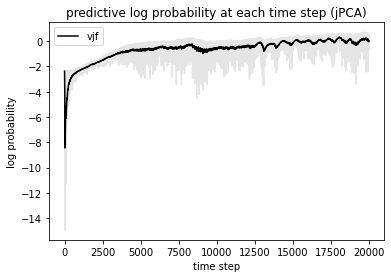

In [104]:
import pandas as pd
def ewma(data, com):
    return np.array(pd.DataFrame(data=dict(data=data)).ewm(com).mean()['data'])

plt.plot(vjf[t], color='grey', alpha=0.2)

ax = plt.gca()
ax.plot(ewma(vjf[t], 100), color='black', label='vjf')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel('time step')
ax.set_ylabel('log probability')
ax.set_title('predictive log probability at each time step (jPCA)')
ax.legend()

## 8. Compute the mean and std of the last half of the time points (for Table 1)

In [107]:
nn = vjf.shape[1]
vjf[t][nn//2:].mean(), vjf[t][nn//2:].std()

(-0.17448249337361935, 0.5121917192313542)